In [39]:
import os
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json

warnings.filterwarnings('ignore')

In [40]:
####################### SET PARAMETERS #################

In [41]:

# Select predetermined track
# site = "utqiagvik"
site = "blackrock"

#input options
# "len": recommended 20.0
segLength = 10
# "res":  recommended 10.0
res = 5
# zonal status radius
zonal_radius = 5

#output options
# Save flag (0: dont save
sFlag = 0

along_track_spread = 5.0

photon_count = 5

confidence = 2

maxi = 6

# DEM
dem_to_sample = "usgs3dep-1meter-dem" # arcticdem-mosaic or usgs3dep-1meter-dem


# path = f"~/surfit/data/"
path = os.getcwd()
filename = f"{path}/{site}_ATL06_segLen{int(segLength)}m_stepDist{int(res)}m_sampled_{dem_to_sample}_at_{int(zonal_radius)}m_conf2.csv"

In [42]:
filename

'/home/jovyan/surfit/contributors/ben/blackrock_ATL06_segLen10m_stepDist5m_sampled_usgs3dep-1meter-dem_at_5m_conf2.csv'

In [43]:
########################### BEGIN 

In [44]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

In [45]:
'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = f'{gid[2][6:8]}'
    version = f'{gid[3]}'
    release = f'{gid[4][0:2]}'
    
# gt dictionary
gtDict = {"gt1l": 10, "gt1r": 20, "gt2l": 30, "gt2r": 40, "gt3l": 50, "gt3r": 60}


In [46]:
# Load JSON data from a file into a Python dictionary
with open('/home/jovyan/surfit/data/icesat2_tracks.json') as json_file:
    data_dict = json.load(json_file)

In [47]:
#Unpack site metadata
pregion = f"/home/jovyan/surfit/data/bbox_{site}.geojson" 
region = sliderule.toregion(pregion)["poly"]
gid = data_dict[site]["granule_id"]
beam = data_dict[site]["beam"]
unpackGranuleID(gid)

In [48]:
########################### Check 3DEP availability before going on

In [49]:
geojson_dem_area = earthdata.tnm(short_name="Digital Elevation Model (DEM) 1 meter", polygon=region)

<AxesSubplot: >

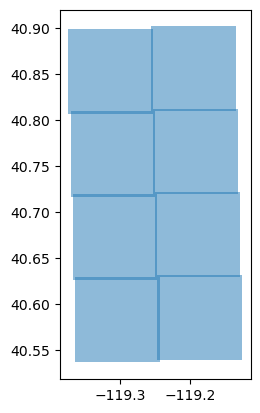

In [50]:
tnm_gdf = gpd.read_file(geojson_dem_area)
tnm_gdf.plot(alpha=0.5)

In [51]:
# # Build ATL06 Request
# parms = {
#     "poly": region,
#     "cnf": confidence,
#     "ats": along_track_spread,
#     "cnt": photon_count,
#     "len": segLength,
#     "res": res,
#     "cycle": cycle,
#     "maxi": maxi,
    
#     # get zonal stats of dem
#     "samples" : {
#             "dem_stats": {"asset": dem_to_sample, 
#                           "radius": zonal_radius, 
#                           "zonal_stats": True, 
#                           "catalog": geojson_dem_area }
#         }
# }

# parms = {
#     "poly": region,
#     "len": segLength,
#     "res": res,
#     "cnf": 4,
#     "atl08_class": [
#         "atl08_ground"
#     ],
#     "maxi": 6,
#     "ats": 20.0,
#     "cnt": 5,
#     # "H_min_win": 3.0,
#     # "sigma_r_max": 5.0,
#     "samples" : {
#             "dem_stats": {"asset": dem_to_sample, 
#                           "radius": zonal_radius, 
#                           "zonal_stats": True, 
#                           "catalog": geojson_dem_area }
# }
# }


parms = {
    "poly": region,
    "srt": 0,
    "len": segLength,
    "res": res,
    "cnf": confidence,
    "maxi": 6,
    "ats": along_track_spread,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": 8,
    "samples" : {
        "dem_stats": {"asset": dem_to_sample, 
                      "radius": zonal_radius, 
                      "zonal_stats": True, 
                      "catalog": geojson_dem_area }
}}

In [52]:
# Latch Start Time
#perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms, "nsidc-s3")
ss_atl06_sr = atl06_sr[(atl06_sr.rgt == rgt)*atl06_sr.loc[:, 'gt']==gtDict[beam]]


# Latch Stop Time
#perf_stop = time.perf_counter()

# Display Statistics
#perf_duration = perf_stop - perf_start
#print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Reference Ground Tracks: {}".format(ss_atl06_sr["rgt"].unique()))
print("Cycles: {}".format(ss_atl06_sr["cycle"].unique()))
print("Received {} elevations".format(ss_atl06_sr.shape[0]))

Reference Ground Tracks: [204]
Cycles: [8]
Received 5275 elevations


In [53]:
ss_atl06_sr

,distance,h_mean,cycle,rms_misfit,dh_fit_dx,gt,spot,pflags,dh_fit_dy,w_surface_window_final,...,dem_stats.median,dem_stats.mean,dem_stats.flags,dem_stats.stdev,dem_stats.max,dem_stats.mad,dem_stats.file_id,dem_stats.min,dem_stats.count,dem_stats.value
time,,,,,,,,,,,,,,,,,,,,,
2020-07-08 17:09:55.677050368,4.519814e+06,1403.623079,8,0.414972,0.109479,10,1,0,0.0,3.000000,...,[1403.9685699736906],[1403.9579378001738],[0],[0.22120038228035055],[1404.348086575253],[0.18763909429306036],[4294967296],[1403.470889309628],[81],[1403.9685699736906]
2020-07-08 17:09:55.677757696,4.519819e+06,1403.877412,8,0.319194,-0.003353,10,1,0,0.0,3.000000,...,[1403.8856575107843],[1403.90612764726],[0],[0.23163311299248882],[1404.3400032139093],[0.19566317539244754],[4294967296],[1403.4187385654718],[81],[1404.0078498935968]
2020-07-08 17:09:55.678464000,4.519824e+06,1403.499325,8,0.458728,-0.119701,10,1,0,0.0,3.113030,...,[1403.4187118628192],[1403.327421353559],[0],[0.5211545423896753],[1404.2254745581317],[0.4414146224494541],[4294967296],[1402.2059433081317],[81],[1403.4531356909442]
2020-07-08 17:09:55.679171328,4.519829e+06,1402.859830,8,0.535711,-0.112643,10,1,0,0.0,3.000000,...,[1402.7369224821718],[1402.7682538623815],[0],[0.435997421215868],[1403.7166588102968],[0.37149261349024226],[4294967296],[1402.0814049040468],[81],[1402.2059166227968]
2020-07-08 17:09:55.679878656,4.519834e+06,1403.049752,8,0.797129,0.160811,10,1,0,0.0,5.645167,...,[1403.7166321315995],[1403.6203397536103],[0],[0.7906431311615042],[1405.058306936287],[0.656415923341888],[4294967296],[1402.1238586940995],[81],[1403.7166321315995]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08 17:09:59.390652928,4.546223e+06,1185.262520,8,0.245837,-0.018281,10,1,0,0.0,3.000000,...,[1185.2123391645573],[1185.241935940696],[0],[0.13630726169525337],[1185.6847512739323],[0.11224883395977014],[4294967299],[1185.0499856489323],[81],[1185.2186868208073]
2020-07-08 17:09:59.391355136,4.546228e+06,1185.163875,8,0.192586,-0.011136,10,1,0,0.0,3.000000,...,[1185.2187617806776],[1185.2833625956853],[0],[0.26724287938803665],[1186.066295960365],[0.2026834184122952],[4294967299],[1184.95862994474],[81],[1185.135143616615]
2020-07-08 17:09:59.392057088,4.546233e+06,1185.400272,8,0.489927,0.089173,10,1,0,0.0,3.000000,...,[1185.9447888856585],[1185.8786840438358],[0],[0.5108754240483717],[1186.536463690346],[0.44834254526040523],[4294967299],[1184.943690252846],[81],[1186.139491034096]


In [54]:
ss_atl06_sr.keys()

Index(['distance', 'h_mean', 'cycle', 'rms_misfit', 'dh_fit_dx', 'gt', 'spot',
       'pflags', 'dh_fit_dy', 'w_surface_window_final', 'n_fit_photons',
       'h_sigma', 'rgt', 'segment_id', 'geometry', 'dem_stats.time',
       'dem_stats.median', 'dem_stats.mean', 'dem_stats.flags',
       'dem_stats.stdev', 'dem_stats.max', 'dem_stats.mad',
       'dem_stats.file_id', 'dem_stats.min', 'dem_stats.count',
       'dem_stats.value'],
      dtype='object')

In [55]:
dem_values = ss_atl06_sr["dem_stats.value"].values

for i in range(len(dem_values)):
    if isinstance(dem_values[i], np.ndarray):
        dem_values[i] = dem_values[i][0]
        
# dem_values

Text(0, 0.5, 'Elevation (km)')

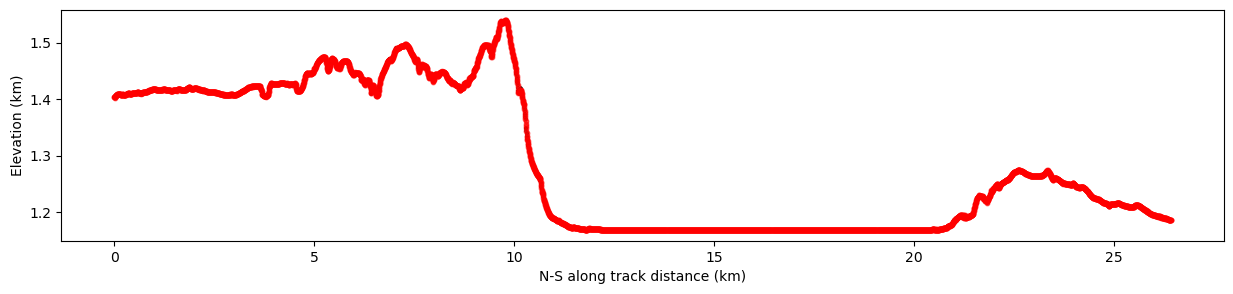

In [56]:
plt.figure(figsize=[15, 3])
plt.scatter((ss_atl06_sr['distance']-np.min(ss_atl06_sr['distance']))/1000, ss_atl06_sr.h_mean/1000, 
            s=10, marker="+", color='black', alpha=0.6)
plt.scatter((ss_atl06_sr['distance']-np.min(ss_atl06_sr['distance']))/1000, dem_values/1000, 
            s=10, marker="o", color='red', alpha=0.6)
plt.title("")
plt.xlabel('N-S along track distance (km)')
plt.ylabel('Elevation (km)')
# plt.xlim([11, 11.1])
# plt.ylim([0.1, 1.3])

In [57]:
# Save geodataframe as csv
print(f'Saving file as {filename}')
ss_atl06_sr.to_csv(filename)

Saving file as /home/jovyan/surfit/contributors/ben/blackrock_ATL06_segLen10m_stepDist5m_sampled_usgs3dep-1meter-dem_at_5m_conf2.csv
